# PINNs on Graphs

This notebook accompanies the paper


---

In this notebook, we describe and illustrate the methodology proposed in the aforementioned paper.
Here, we deal with the solution of a drift-diffuion equation on a metric graph.
A metric graph is an undirected graph that consists of a set of vertices $\mathcal V$ and edges $\mathcal E$ where in contrast to combinatorial graphs a length $l_e$ is assigned to each edge $e \in \mathcal E$.
Each edge $e \in \mathcal E$ connects a pair of nodes $(v_{e_a},v_{e_b})$ with $v_{e_a}, v_{e_b} \in \mathcal V$

We consider the drift-diffusion equation posed on each edge

$$
\partial_t u = \partial_x ( \varepsilon \partial_x \rho_e - f(\rho_e) \partial_x V_e), \quad e \in \mathcal E
$$

where $\rho_e : [0,l_e] \times (0,T) \to \mathbb{R}_+$ describes, on each edge, the concentration of some quantity while $V_e: [0,l_e] \times(0,T)\to \mathbb{R}_+$ is a given potential and $\varepsilon > 0$ a given constant, typically small.

To make this a well-posed problem, we need a set of initial conditions as well as coupling conditions in the vertices.
- For vertices $v \in \mathcal V_{\mathcal K} \subset \mathcal V$, we apply homogeneous Neumann-Kirchhoff conditions, i.e., there holds
$$
\sum_{e \in \mathcal{E}_v} J_e \, n_{e} (v) = 0 \quad v \in \mathcal V_{\mathcal K},
$$
where we additionally ask the solution to be continuous over the edges, i.e.
$$
p_e(v) = p_{e^{'}}(v)
\quad \text{for all } v \in \mathcal{V}_{\mathcal K}, e, e^{'} \in \mathcal{E}_v
$$
with $\mathcal E_v$ the edge set incident to the vertex $v$.
- For vertices $v \in \mathcal V_{\mathcal D} := \mathcal V \setminus \mathcal{V}_{\mathcal K}$ the solution fulfills flux boundary conditions
$$
J_e \, n_e (v) = - \alpha_v \, (1-u_v) + \beta_v \, u_v \quad \text{for all } e \in \mathcal E_v.
$$

Import necessary packages.

In [31]:
import tensorflow as tf
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In [32]:
from quantumGraphSolverFVM import QuantumGraphSolverFVM
import graph

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN

## Set up class GraphPINNs

Next, we define the class `GraphPINN`, which is employed in the subsequent code.
The idea is to have one vanilla `PINN` for each edge which are connected via boundary and vertex conditions which are enforced weakly.

---

First, we define the model for a `PINN` which consists of one scaling layer, a number of fully connected hidden layers and one final output layer.

In [34]:
from tensorflow.keras import backend as Kback
def my_act(x):
    e1 = Kback.exp(x)
    e2 = Kback.exp(-x)
    return Kback.log(e1+e2)

In [35]:
# Define model architecture
class PINN(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 output_dim=1,
                 num_hidden_layers=2,
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.input_dim = lb.shape[0]
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        
        # Inititialize num_hidden_layers many fully connected dense layers
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                                             activation=tf.keras.activations.get(
                                                 activation),
                                             kernel_initializer=kernel_initializer) for _ in range(self.num_hidden_layers)]
        
        # Output layer
        #self.out = tf.keras.layers.Dense(output_dim, activation=None)
        self.out = tf.keras.layers.Dense(output_dim, activation='tanh')
        
    def call(self, X):
        """Forward-pass through neural network."""
        
        #Z = self.scale(X)
        Z = X
        
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
            
        return self.out(Z)

In [36]:
# Define model architecture
class PINN_ResNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 ResNetLayers=3,
                 ResNetNeurons=16,
                 ResNetStepsize=1.0,
                 ResNetActivation='softplus',
                 **kwargs):
        
        super(PINN_ResNet, self).__init__(**kwargs)
        
        #RNact = tf.keras.activations.get(ResNetActivation)
        #RNact = my_act
        RNact = tf.keras.activations.get('sigmoid')

        
        self.ResNetLayers = ResNetLayers
        self.ResNetStepsize = ResNetStepsize

        self.ResNet = [tf.keras.layers.Dense(ResNetNeurons,
                                        activation=RNact) for _ in range(self.ResNetLayers)]
        self.wb = tf.keras.layers.Dense(1)
        self.A = tf.keras.layers.Dense(2, use_bias=False)
        self.c = tf.keras.layers.Dense(1, use_bias=False)
        
        #self.num_hidden_layers = num_hidden_layers
        self.input_dim = lb.shape[0]
        self.output_dim = 1
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        
        # Output layer
        #self.out = tf.keras.layers.Dense(1, activation='sigmoid')

        
    def call(self, input_tensor, training=False):
        """Forward-pass through neural network."""
        N = self.ResNet[0](input_tensor, training=training)
        for i in range(1, self.ResNetLayers):
            N = N + self.ResNetStepsize * self.ResNet[i](N, training=training)
        Phi = self.wb(N, training=training)
        #print(input_tensor)
        As = self.A(input_tensor, training=training)
        #print(As)
        sAs = tf.keras.layers.Dot(axes=(1))([input_tensor, As])
        #print(sAs)
        Phi += .5 * sAs
        #print(Phi.shape)
        Phi += self.c(input_tensor, training=training)
            
        return Phi
        #return self.out(Phi)

In [37]:
# Define model architecture
class PINN_CNN(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 **kwargs):
        
        super().__init__(**kwargs)

        self.input_dim = lb.shape[0]
        self.lb = lb
        self.ub = ub

        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.layers.Conv1D(5, 1, activation='sigmoid'))
        self.model.add(tf.keras.layers.AveragePooling1D(1))
        self.model.add(tf.keras.layers.Conv1D(15, 1, activation='sigmoid'))
#         self.model.add(tf.keras.layers.MaxPool1D(1))
        self.model.add(tf.keras.layers.AveragePooling1D(1))
        self.model.add(tf.keras.layers.Conv1D(5, 1, activation='sigmoid'))
        self.model.add(tf.keras.layers.AveragePooling1D(1))
        self.model.add(tf.keras.layers.Conv1D(1, 1, activation='sigmoid'))
        
    def call(self, X):
        Z = self.model(tf.reshape(X, (X.shape[0], 1, 2)))
            
        return tf.reshape(Z, (X.shape[0], 1))

In [38]:
# Define model architecture
# class PINN_ResNet_CNN(tf.keras.Model):
#     """ Set basic architecture of the PINN model."""

#     def __init__(self, lb, ub,
#                  ResNetLayers=3,
#                  ResNetNeurons=16,
#                  ResNetStepsize=1.0,
#                  ResNetActivation='softplus',
#                  **kwargs):
        
#         super(PINN_ResNet_CNN, self).__init__(**kwargs)
        
#         #RNact = tf.keras.activations.get(ResNetActivation)
#         #RNact = my_act
#         RNact = tf.keras.activations.get('sigmoid')

        
#         self.ResNetLayers = ResNetLayers
#         self.ResNetStepsize = ResNetStepsize

#         self.ResNet = tf.keras.models.Sequential()
#         self.ResNet.add(tf.keras.layers.Conv1D(5, 1, activation='sigmoid'))
#         self.ResNet.add(tf.keras.layers.AveragePooling1D(1))
#         self.ResNet.add(tf.keras.layers.Conv1D(16, 1, activation='sigmoid'))
        
        
#         self.wb = tf.keras.layers.Dense(1)
#         self.A = tf.keras.layers.Dense(2, use_bias=False)
#         self.c = tf.keras.layers.Dense(1, use_bias=False)
        
#         #self.num_hidden_layers = num_hidden_layers
#         self.input_dim = lb.shape[0]
#         self.output_dim = 1
#         self.lb = lb
#         self.ub = ub

#         # Define NN architecture
        
#         # Output layer
#         #self.out = tf.keras.layers.Dense(1, activation='sigmoid')
        
    
#     def apply(self, X):
#         Z = self.ResNet(tf.reshape(X, (X.shape[0], 1, 2)))
            
#         return tf.reshape(Z, (X.shape[0], 1))
        
#     def call(self, input_tensor, training=False):
#         """Forward-pass through neural network."""
#         N = self.apply(input_tensor)
#         for i in range(1, self.ResNetLayers):
#             N = N + self.ResNetStepsize * self.apply(N)
#         Phi = self.wb(N, training=training)
#         #print(input_tensor)
#         As = self.A(input_tensor, training=training)
#         #print(As)
#         sAs = tf.keras.layers.Dot(axes=(1))([input_tensor, As])
#         #print(sAs)
#         Phi += .5 * sAs
#         #print(Phi.shape)
#         Phi += self.c(input_tensor, training=training)
            
#         return Phi
#         #return self.out(Phi)

In [39]:
# Define model architecture
class PINN_LSTM(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 **kwargs):
        
        super().__init__(**kwargs)

        self.input_dim = lb.shape[0]
        self.lb = lb
        self.ub = ub

        self.model = Sequential()
        self.model.add(LSTM(32, activation='sigmoid', return_sequences=True))
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(32, activation='sigmoid'))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(16, activation='sigmoid'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(1, activation='sigmoid'))
        
    def call(self, X):
        Z = tf.reshape(X, (X.shape[0], 1, 2))
        return self.model(Z)

In [40]:
# Define model architecture
class PINN_RNN(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 **kwargs):
        
        super().__init__(**kwargs)

        self.input_dim = lb.shape[0]
        self.lb = lb
        self.ub = ub

        self.model = Sequential()
        self.model.add(SimpleRNN(32, activation='sigmoid', return_sequences=True))
        self.model.add(Dropout(0.2))
        self.model.add(SimpleRNN(32, activation='sigmoid'))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(16, activation='sigmoid'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(1, activation='sigmoid'))
        
    def call(self, X):
        Z = tf.reshape(X, (X.shape[0], 1, 2))
        return self.model(Z)

In [41]:
DTYPE = 'float64'
# Lower bounds
lb = tf.constant([0, 0], dtype=DTYPE)

# Upper bounds
ub = tf.constant([10, 1], dtype=DTYPE)

pinn = PINN_ResNet(lb=lb, ub=ub)
pinn(tf.constant([[1., 1.],[1., 0.], [0., 1.]]))

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[2.34005171],
       [1.07972465],
       [1.53176603]])>

In [42]:
tmp=pinn.ResNet[0]
tmp.weights[0]

<tf.Variable 'pinn__res_net_3/dense_30/kernel:0' shape=(2, 16) dtype=float64, numpy=
array([[-0.17795006, -0.20341376, -0.3694263 ,  0.111474  , -0.41263971,
        -0.48857788,  0.4824173 , -0.40432808,  0.49078265, -0.22422899,
        -0.4833853 , -0.43133664, -0.25151818, -0.26135695,  0.41080988,
         0.08806274],
       [ 0.13849741,  0.39582095,  0.40581083, -0.07117935, -0.30008873,
         0.03261002,  0.24076866,  0.53838926,  0.06583591,  0.11520862,
         0.28082041, -0.17757758, -0.53511135, -0.04130834,  0.29329527,
         0.21592053]])>

In this notebook, we rely on the package [NetworkX](https://networkx.org/).
An alternative approach would be to employ [igraph](https://igraph.org/), which seems to be more lightweight.

Next, we set up the class for a graph PINN which takes either an adjacency matrix $A$ or a `MultiDiGraph` as input `inp` to define the network as well as the Dirichlet data as a list of pairs $(i, u_i)_{i=1}^{n_D}$ corresponding to $u(v_i) = u_i$.
*Notes*:
- we define our graph as a `MultiDiGraph` since graphs imported from [OpenStreetMap](https://www.openstreetmap.de/) obey this format.

In [43]:
import networkx as netx

class GraphPINN():
    
    def __init__(self, inp, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, Type = 'FNN'):
        
        if isinstance(inp, netx.classes.multidigraph.MultiGraph):
            self.G = inp
            self.A = netx.adjacency_matrix(G).toarray()
            
        elif tf.is_tensor(A) and len(A.shape)==2:
            # Store adjacency matrix
            self.A = A
            # Define networkx multigraph
            self.G = netx.MultiDiGraph(A.numpy())
            
        else:
            raise ValueError('Check input type of GraphPINN.')
        
        self.dirichletNodes = dirichletNodes
        self.dirichletAlpha = dirichletAlpha
        self.dirichletBeta = dirichletBeta
        
        self.lb = lb
        self.ub = ub
        
        # Get number of vertices
        self.n_v = self.A.shape[0]
        
        # Determine lists of edges and lengths
        self._determineEdgeList()
        
        # Determine list of vertices and incoming as well as outgoing edges
        self._determineVertexList()
        
        self.type = Type
        
        # Setup list of neural networks
        self._setupNNs()
        
        # Determine graph layout if necessary
        self.pos = netx.kamada_kawai_layout(self.G)
        
        
    def _determineEdgeList(self):
        """Determine edge matrix and weight vector.
        This could also be accomplished by a loop over `G.edges`:
            for e in G.edges:
                print(e)
        """
        
        self.E = []
        self.W = []
        
        for i in range(self.n_v):
            for j in range(i + 1, self.n_v):
                aij = self.A[i, j]
                if aij > 0:
                    #print('Connectivity between i: {} and j: {}'.format(i,j))
                    self.E.append([i, j])
                    self.W.append(aij.numpy())

        # Get number of edges
        self.ne = len(self.E)
        
    def _determineVertexList(self):
        
        self.Vin = [[] for _ in range(self.n_v)]
        self.Vout = [[] for _ in range(self.n_v)]
        
        for i, e in enumerate(self.E):
            # Unpack edge
            vin, vout = e
            self.Vin[vout].append(i)
            self.Vout[vin].append(i)            
            
        self.innerVertices = np.setdiff1d(np.arange(self.n_v), self.dirichletNodes)
            
    def _setupNNs(self):
        
        self.NNs = []
        if self.type == 'ResNet':
            for i, e in enumerate(self.E):
                self.NNs.append(PINN_ResNet(lb=self.lb, ub=self.ub))
        elif self.type == 'FNN':
            for i, e in enumerate(self.E):
                self.NNs.append(PINN(lb=self.lb, ub=self.ub))
        elif self.type == 'CNN':
            for i, e in enumerate(self.E):
                self.NNs.append(PINN_CNN(lb=self.lb, ub=self.ub))
        elif self.type == 'ResNetCNN':
            for i, e in enumerate(self.E):
                self.NNs.append(PINN_ResNet_CNN(lb=self.lb, ub=self.ub))
        elif self.type == 'LSTM':
            for i, e in enumerate(self.E):
                self.NNs.append(PINN_LSTM(lb=self.lb, ub=self.ub))
        elif self.type == 'RNN':
            for i, e in enumerate(self.E):
                self.NNs.append(PINN_RNN(lb=self.lb, ub=self.ub))
        else:
            print('No valid type passed! FNN is used.')
            for i, e in enumerate(self.E):
                self.NNs.append(PINN(lb=self.lb, ub=self.ub))
        
    
        print('Initialized {:d} neural nets.'.format(len(self.NNs)))
    
    def plotGraph(self, **kwargs):

        netx.draw(self.G, pos=self.pos, with_labels=True, **kwargs)

### Example

First, we define a network which is determined by its
adjacency matrix $A \in \mathbb{R}_+^{n_v \times n_v}$ with $n_v$ the number of vertices.
Note that this matrix is not symmetric, as it belongs to a *directed* graph.
Here, an entry $a_{i,j} > 0$ indicates that there is an edge starting in vertex $i$ and ending in vertex $j$ with length $a_{i,j}$.

In [56]:
#DTYPE = 'float32'
DTYPE = 'float64'
adj = 2
tf.keras.backend.set_floatx(DTYPE)
time_dependent = False

# Specify adjacency matrix
if adj == 1:
    A = tf.constant([[0, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 0, 1, 0, 0, 0],
                 [0, 0, 0, 1, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0]
                ], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 1.
    xmin = 0.
    xmax = 0.1
    
    u0 = lambda x : 0
    dirichletNodes = np.array([0, 7])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.8, 0.0])
    dirichletBeta = np.array([0.0, 0.5])
                              
    
    eps = 0.01
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)

    
elif adj == 2:
    A = tf.constant([[0, 1],
                 [0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    eps = .01

    dirichletNodes = np.array([0, 1])
    dirichletAlpha = np.array([0.7, 0.0])
    dirichletBeta = np.array([0.0, 0.8])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.
        #return .5 +(.5*-tf.sin(x*np.pi))
    
elif adj == 3:
    A = tf.constant([[0, 1, 0],
                     [0, 0, 1],
                     [0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 0.5
    
    eps = .01

    dirichletNodes = np.array([0, 2])
    
    dirichletAlpha = np.array([0.7, 0.0])
    dirichletBeta = np.array([0.0, 0.8])
    #time_dependent = True
    #dirichletAlpha = np.array([lambda x: 0.7*x/10, lambda x: 0.0*x])
    #dirichletBeta = np.array([lambda x: 0.0, lambda x: 0.8*x/10])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.
    
elif adj == 4:
    A = tf.constant([[0, 1, 0, 0],
                     [0, 0, 1, 1],
                     [0, 0, 0, 0],
                     [0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    eps = .01

    dirichletNodes = np.array([0, 2, 3])
    dirichletAlpha = np.array([0.7, 0.0, 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.0])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.
    
elif adj == 0:
    A = tf.constant([[0, 0, 1,0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1],
                 [0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 4.
    xmin = 0.
    xmax = 1.
    
    u0 = lambda x : 0
    dirichletNodes = np.array([0, 1, 3])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.8, 0.8, 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.])
                              
    
    eps = 1e-6
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
elif adj == 5:
    A = tf.constant([[0, 0, 1, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 1, 0, 0],
                     [0, 0, 0, 0, 1, 1],
                     [0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    dirichletNodes = np.array([0, 1, 4, 5])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.9, 0.3, 0., 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.8, 0.1])
                              
    eps = 1e-2
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.


# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)

# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

Initialized 1 neural nets.
Vin: [[], [0]]
Vout: [[0], []]


{0: array([1.00000000e+00, 4.37113883e-08]),
 1: array([-1.00000000e+00, -4.37113883e-08])}

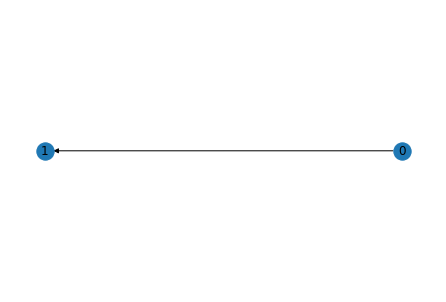

In [57]:
%matplotlib inline

gPINN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, 'ResNet')
gPINN.plotGraph()
print('Vin:', gPINN.Vin)
print('Vout:', gPINN.Vout)
gPINN.E
gPINN.pos

Draw collocation points uniformly or take them equidistantly distributed.

In [58]:
mode = 'deterministic'
mode = 'uniform'

N_0 = 1000
N_b = 1000
N_r = 4000

# Set random seed for reproducible results
tf.random.set_seed(0)

def drawCollocationPoints(N_0, N_b, N_r):
    X_r = tf.random.uniform((N_r,2), lb, ub, dtype=DTYPE)
    
    # Draw uniform sample points for initial boundary data
    t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
    x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
    X_0 = tf.concat([t_0, x_0], axis=1)
    
    # Boundary data
    t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
    x_l = tf.ones((N_b,1), dtype=DTYPE) * lb[1]
    X_l = tf.concat([t_b, x_l], axis=1)
    
    x_u = tf.ones((N_b,1), dtype=DTYPE) * ub[1]
    X_u = tf.concat([t_b, x_u], axis=1)
    
    X_b = tf.concat([X_l, X_u], axis=0)

    # Draw uniformly sampled collocation points
    t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
    x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
    X_r = tf.concat([t_r, x_r], axis=1)
    # X_data = tf.concat([X_0, X_b, X_r], axis=0)
    return X_r, X_0, X_l, X_u

if mode == 'deterministic':

    # Uniform distributed collocation points
    t_r = tf.linspace(lb[0], ub[0], N_0+1)
    x_r = tf.linspace(lb[1], ub[1], N_b+1)
    tt, xx = tf.meshgrid(t_r,x_r)
    X_r = tf.concat([tf.reshape(tt,(-1,1)), tf.reshape(xx,(-1,1))], axis=1)

elif mode == 'uniform':
    
    X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
    #X_data = tf.concat([X_0, X_b, X_r], axis=0)

Draw collocation points.

Text(0, 0.5, 'x')

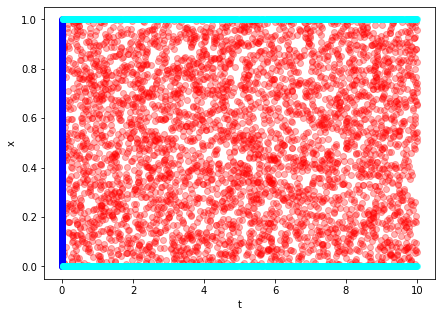

In [59]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
ax.scatter(X_r[:,0].numpy(), X_r[:,1].numpy(),color='red',alpha=0.3)
ax.scatter(X_0[:,0].numpy(), X_0[:,1].numpy(), color='blue', alpha=0.5)
ax.scatter(X_u[:,0].numpy(), X_u[:,1].numpy(), color='cyan', alpha=0.5)
ax.scatter(X_l[:,0].numpy(), X_l[:,1].numpy(), color='cyan', alpha=0.5)
ax.set_xlabel('t')
ax.set_ylabel('x')

## Set up class for time-dependent equations

We have to handle different kinds of boundary and vertex conditions:
- all inner vertices: Kirchhoff-Neumann conditon
- initial time conditions on all edges
- Dirichlet conditions on selected vertices as long as it is an inflowing node

In [60]:
from time import time

class graphPINNSolver(object):
    def __init__(self, graphPINN, Xr, X0, Xl, Xu):
        
        self.graphPINN = graphPINN
        self.ne = self.graphPINN.ne
        
        self._updateData(Xr, X0, Xl, Xu)
        
        

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
        
        # Call each network once to initialize trainable variables
        self.trainable_variables = []
        for i in range(self.ne):
            self.graphPINN.NNs[i](tf.constant([[1., 1.]], dtype=DTYPE))
            self.trainable_variables.append(self.graphPINN.NNs[i].trainable_variables)
        
        # Setup auxiliary variables for vertex values to ensure continuity
        self._setupVertexVariables()
        
        for i, v in enumerate(self.graphPINN.innerVertices):
            self.trainable_variables.append([self.vertexVals[i]])
        
        self.nvar = len(self.trainable_variables)
        
    def _updateData(self, Xr, X0, Xl, Xu):
        self.Xr = Xr
        self.X0 = X0
        self.Xl = Xl
        self.Xu = Xu
        
        self.nr = Xr.shape[0]
        self.n0 = X0.shape[0]
        self.nb = Xl.shape[0]

    def _setupVertexVariables(self):
        
        self.vertexVals = []
        for _ in self.graphPINN.innerVertices:
            self.vertexVals.append(tf.Variable(tf.random.uniform(shape=(self.nb,), dtype=DTYPE), trainable=True))

    def _fvals0(self, t, x):

        # Initialize lists for values and derivatives
        u = []
        tx = tf.stack([t, x], axis=1)
        for i in range(self.ne):
            u.append(self.graphPINN.NNs[i](tx)[:,0])

        return u
    
    def _fvals1(self, t, x):
        
        # Initialize lists for values and derivatives
        u = []
        ux = []
        ut = []
        
        for i in range(self.ne):
            
            with tf.GradientTape(persistent=True) as tape:
                # Watch variables representing t and x during this GradientTape
                tape.watch(t)
                tape.watch(x)

                tx = tf.stack([t, x], axis=1)

                # Compute current values u(t,x)
                u.append(self.graphPINN.NNs[i](tx)[:, 0])
            ut.append(tape.gradient(u[i], t))
            ux.append(tape.gradient(u[i], x))
            
            del tape
                
        return u, ut, ux
    
    def _fvals2(self, t, x):
        
        # Initialize lists for values and derivatives
        u = []
        ux = []
        ut = []
        uxx = []
        
        for i in range(self.ne):
            
            with tf.GradientTape(persistent=True) as tape:
                # Watch variables representing t and x during this GradientTape
                tape.watch(t)
                tape.watch(x)

                tx = tf.stack([t, x], axis=1)

                # Compute current values u(t,x)
                u.append(self.graphPINN.NNs[i](tx)[:,0])
                ux.append(tape.gradient(u[i], x))
                
            ut.append(tape.gradient(u[i], t))
            uxx.append(tape.gradient(ux[i], x))
            
            del tape
                
        return u, ut, ux, uxx
    
    def determine_losses(self):
        # Short-hand notation of mean-squared loss
        mse = lambda x : tf.reduce_mean(tf.square(x))
        
        ###################################
        ### Residual loss for all edges ###
        ###################################
        u, ut, ux, uxx = self._fvals2(self.Xr[:,0], self.Xr[:,1])
        
        loss_res = 0
        for i in range(self.ne):
            res_e = pde(u[i], ut[i], ux[i], uxx[i])
            loss_res += mse(res_e)
        
        
        ###################################
        ### Initial conds for all edges ###
        ###################################
        
        u = self._fvals0(self.X0[:,0], self.X0[:,1])
        
        loss_init = 0
        for i in range(self.ne):
            res_e = u[i] - initial_cond(self.X0[:,1])
            loss_init += mse(res_e)
        
        ###################################
        ###   Continuity in vertices    ###
        ###################################
        
        ul, ult, ulx = self._fvals1(self.Xl[:,0], self.Xl[:,1])
        uu, uut, uux = self._fvals1(self.Xu[:,0], self.Xu[:,1])
        loss_cont = 0
        
        for i, v in enumerate(self.graphPINN.innerVertices):
            
            for j in self.graphPINN.Vin[v]:
                val = uu[j] - self.vertexVals[i]
                loss_cont += mse(val)

            for j in self.graphPINN.Vout[v]:
                val = ul[j] - self.vertexVals[i]
                loss_cont += mse(val)

        #####################################
        ### Kirchhoff-Neumann in vertices ###
        #####################################
        
        # Kirchhoff-Neumann condition in center nodes
        loss_KN = 0
        for i in self.graphPINN.innerVertices:
            
            val = 0
            print('Kirchhoff-Neumann in node ', i)
            for j in self.graphPINN.Vin[i]:
                print('incoming edge:', j)
                val += flux(uu[j], uux[j])
                
            for j in self.graphPINN.Vout[i]:
                print('outgoing edge:', j)
                val -= flux(ul[j], ulx[j])
            loss_KN += mse(val)
        
        #####################################
        ###      Inflow/Outflow conds     ###
        #####################################
            
        loss_D = 0
        for i,v in enumerate(self.graphPINN.dirichletNodes):
            
            if time_dependent:
                alpha = self.graphPINN.dirichletAlpha[i](self.Xl[:,0])
                beta = self.graphPINN.dirichletBeta[i](self.Xl[:,0])
            else:
                alpha = self.graphPINN.dirichletAlpha[i]
                beta = self.graphPINN.dirichletBeta[i]
            
            print('\nin node ', v, 'alpha ', alpha, 'beta ', beta)
            val = 0
            for j in self.graphPINN.Vin[v]:
                print('outflow: ', j)
                val += flux(uu[j], uux[j]) \
                    - beta * (uu[j])
                #loss_D += mse(val)

            for j in self.graphPINN.Vout[v]:
                print('inflow: ', j)
                val += -flux(ul[j], ulx[j]) \
                    + alpha * (1-ul[j])
                #loss_D += mse(val)
            loss_D += mse(val)
        print(loss_res)
        print(loss_init)
        print(loss_cont)
        print(loss_KN)
        print(loss_D)
        return loss_res, loss_init, loss_cont, loss_KN, loss_D
    
    def loss_fn(self):
        
        loss_res, loss_init, loss_cont, loss_KN, loss_D = self.determine_losses()
        
        loss = loss_res + loss_init + loss_cont + loss_KN + loss_D

        return loss
    
    @tf.function
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.trainable_variables)
            loss = self.loss_fn()

        g = tape.gradient(loss, self.trainable_variables)
        del tape

        return loss, g
    
    
    def solve_with_TFoptimizer(self, optimizer, N=1001):
        """This method performs a gradient descent type optimization."""
        
        self.callback_init()
        
        for i in range(N):
            loss, g = self.get_grad()

            # Perform gradient descent step
            for j in range(self.nvar):
                optimizer.apply_gradients(zip(g[j], self.trainable_variables[j]))

            self.current_loss = loss.numpy()
            self.callback()
            
    def solve_with_ScipyOptimizer(self, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in
        Fortran which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors
            # and unknown parameters
            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    shape_list.append(v.shape)
                    weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list


        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0

            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    vs = v.shape

                    # Weight matrices
                    if len(vs) == 2:
                        sw = vs[0] * vs[1]
                        new_val = tf.reshape(
                            weight_list[idx:idx + sw], (vs[0], vs[1]))
                        idx += sw

                    # Bias vectors
                    elif len(vs) == 1:
                        new_val = weight_list[idx:idx+vs[0]]
                        idx += vs[0]

                    # Variables (in case of parameter identification setting)
                    elif len(vs) == 0:
                        new_val = weight_list[idx]
                        idx += 1

                    # Assign variables (Casting necessary since scipy requires float64 type)
                    v.assign(tf.cast(new_val, DTYPE))

        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from tfp.optimizer."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad()
            # Flatten gradient
            grad_flat = []
            for i in range(len(self.trainable_variables)):
                for g in grad[i]:
                    grad_flat.extend(g.numpy().flatten())

            # Store current loss for callback function
            self.current_loss = loss

            # Return value and gradient of \phi as tuple
            return loss.numpy().astype(np.float64), np.array(grad_flat, dtype=np.float64)

        self.callback_init()

        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)
    
    def callback_init(self):
        self.t0 = time()
        print(' Iter            Loss    Time')
        print('-----------------------------')
    
    def callback(self, xr=None):
        if self.iter % 20 == 0:
            print('{:05d}  {:10.8e}   {:4.2f}'.format(
                self.iter, self.current_loss, time() - self.t0))
        self.hist.append(self.current_loss)
        self.iter += 1
        
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist, 'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

# Feed Forward Neural Net

In [61]:
gPINN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, 'FNN')
N_0 = 1000
N_b = 1000
N_r = 4000
solver = graphPINNSolver(gPINN, X_r, X_0, X_l, X_u)
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
#lr = 0.01
#optim = tf.keras.optimizers.Adam(learning_rate=lr)
#print('Start with TF optimizer\n')
#solver.solve_with_TFoptimizer(optim, N=1)

Initialized 1 neural nets.


In [62]:
print(len(solver.trainable_variables))
# loss, g = solver.get_grad()
# print(len(g))

1


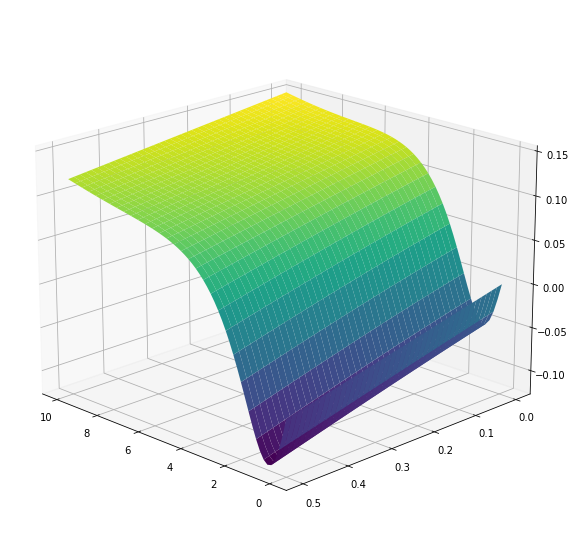

In [21]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver.graphPINN.NNs[Eidx](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)


In [22]:
# Solve with Adam optimizer
lr = 0.01
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver.solve_with_TFoptimizer(optim, N=2001)
#for i in range(20):
    # WARNING: Update of collocation points currently not supported
    # Vertex values are fixed for coordinates at boundary!
    #X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
    #solver._updateData(X_r, X_0, X_l, X_u)
    #solver.solve_with_TFoptimizer(optim, N=301)


Start with TF optimizer

 Iter            Loss    Time
-----------------------------
Kirchhoff-Neumann in node  1
incoming edge: 0
outgoing edge: 1

in node  0 alpha  0.7 beta  0.0
inflow:  0

in node  2 alpha  0.0 beta  0.8
outflow:  1
Tensor("add_3:0", shape=(), dtype=float64)
Tensor("add_5:0", shape=(), dtype=float64)
Tensor("add_7:0", shape=(), dtype=float64)
Tensor("add_11:0", shape=(), dtype=float64)
Tensor("add_18:0", shape=(), dtype=float64)
00000  2.07111742e+00   2.07
00020  1.44187697e-01   2.65
00040  4.70435622e-02   3.20
00060  2.78716030e-02   3.72
00080  2.19782380e-02   4.21
00100  1.95760133e-02   4.73
00120  1.86820290e-02   5.52
00140  1.81952033e-02   6.30
00160  1.77971890e-02   7.06
00180  1.73576800e-02   7.94
00200  1.67987390e-02   8.72
00220  1.60737970e-02   9.50
00240  1.52014839e-02   10.21
00260  1.42965338e-02   11.00
00280  1.34952769e-02   11.91
00300  1.28363006e-02   12.79
00320  1.22787458e-02   13.62
00340  1.17822987e-02   14.45
00360  1.13286256e

In [23]:
print('End with L-BFGS-B algorithm')
coarse = False

#X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r*10)
#solver._updateData(X_r, X_0, X_l, X_u)
if coarse:
    ret = solver.solve_with_ScipyOptimizer(options={'maxiter': 5000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1e-12})
else:
    ret = solver.solve_with_ScipyOptimizer(options={'maxiter': 5000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})
print(ret.message)

End with L-BFGS-B algorithm
 Iter            Loss    Time
-----------------------------
02020  2.93483395e-03   0.56
02040  2.78538222e-03   1.04
02060  2.72416004e-03   1.51
02080  2.65904351e-03   2.07
02100  2.62625475e-03   2.75
02120  2.58534709e-03   3.44
02140  2.56200995e-03   4.10
02160  2.54372402e-03   4.83
02180  2.51630758e-03   5.51
02200  2.49771599e-03   6.23
02220  2.47576438e-03   6.90
02240  2.46291388e-03   7.62
02260  2.45652490e-03   8.31
02280  2.44688982e-03   9.04
02300  2.43273585e-03   9.80
02320  2.42270803e-03   10.54
02340  2.41669212e-03   11.26
02360  2.40741630e-03   11.99
02380  2.40042423e-03   12.68
02400  2.39552157e-03   13.42
02420  2.38742448e-03   14.08
02440  2.37982203e-03   14.78
02460  2.37272546e-03   15.51
02480  2.36524988e-03   16.22
02500  2.35728940e-03   16.94
02520  2.34728988e-03   17.72
02540  2.34214357e-03   18.56
02560  2.33376767e-03   19.26
02580  2.32540865e-03   19.97
02600  2.31561639e-03   20.64
02620  2.30776853e-03   21.

In [24]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
fig = plt.figure(1, figsize=(10, 10))
#fig.canvas.layout.width = '100%'
#fig.canvas.layout.height = '900px'
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
def plot_network(j=0):
    fig = plt.figure(1,clear=True)
    ax = fig.add_subplot(1,1,1, projection='3d')
    t0 = tf.ones_like(xspace)*tspace[j]
    pos = solver.graphPINN.pos
    for i, e in enumerate(solver.graphPINN.E):
        xy = pos[e[0]] + xspace*(pos[e[1]] - pos[e[0]]) / (ub[1]-lb[1])
        #xy = pos[e[0].numpy()] + xspace*(pos[e[1].numpy()] - pos[e[0].numpy()]) 
        #xy = V[e[0].numpy()]+xspace*(V[e[1].numpy()]-V[e[0].numpy()])
        u = solver.graphPINN.NNs[i](tf.concat([t0,xspace],axis=1))
        unum = u.numpy().flatten()
        ax.plot(xy[:,0], xy[:,1], unum)
        #ax.plot(xy[:,0], xy[:,1], unum * (1-unum))
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlim([.0,1.0])
    #ax.set_zlabel('$u_\\theta(x,y)$')
    ax.view_init(12, 135)
    return u

j_slider = widgets.IntSlider(min=0,max=Nt,step=1)
interactive_plot = interactive(plot_network, j=j_slider)
output = interactive_plot.children[-1]
#output.layout.height = '350px'
interactive_plot
#u = plot_network(4)

interactive(children=(IntSlider(value=0, description='j', max=60), Output()), _dom_classes=('widget-interact',…

<Figure size 720x720 with 0 Axes>

Surface plot of function values on a single edge.

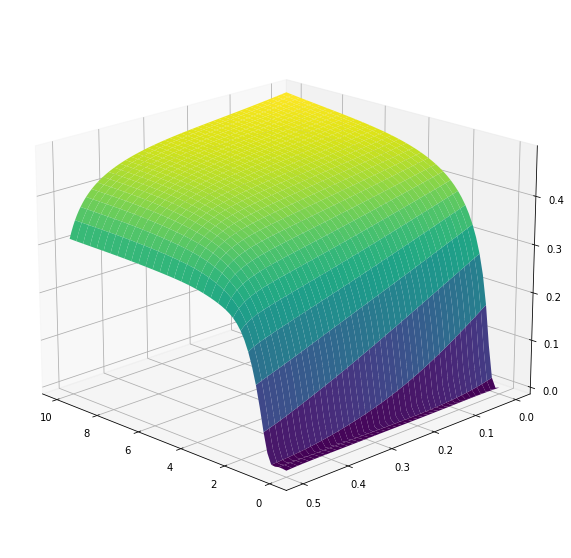

In [28]:
Eidx = 1

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver.graphPINN.NNs[Eidx](TX) #-  solver.graphPINN.NNs[1](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)


# Residual Neural Network

In [25]:
gPINN_ResNet = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub)
N_0 = 1000
N_b = 1000
N_r = 4000
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
solver_ResNet = graphPINNSolver(gPINN_ResNet, X_r, X_0, X_l, X_u)
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)

Initialized 1 neural nets.


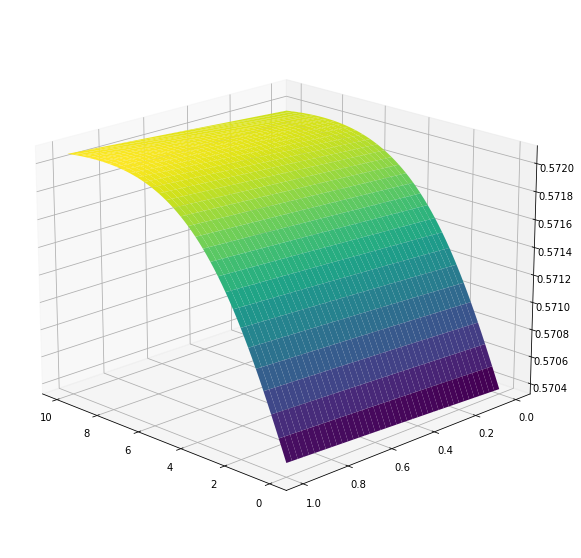

In [26]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_ResNet.graphPINN.NNs[Eidx](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

In [27]:
# Solve with Adam optimizer
lr = 0.05
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver_ResNet.solve_with_TFoptimizer(optim, N=2001)

Start with TF optimizer

 Iter            Loss    Time
-----------------------------

in node  0 alpha  0.7 beta  0.0
inflow:  0

in node  1 alpha  0.0 beta  0.8
outflow:  0
Tensor("add_1:0", shape=(), dtype=float64)
Tensor("add_2:0", shape=(), dtype=float64)
0
0
Tensor("add_9:0", shape=(), dtype=float64)
00000  3.73526859e-01   0.79
00020  1.73463006e-01   1.34
00040  5.59739566e-02   1.95
00060  2.81877606e-02   2.55
00080  7.71466827e-03   3.19
00100  6.22105395e-03   3.81
00120  5.37258559e-03   4.46
00140  4.88399305e-03   5.06
00160  4.40875579e-03   5.68
00180  3.96407431e-03   6.27
00200  3.66259220e-03   6.86
00220  3.24811082e-03   7.43
00240  2.98049367e-03   8.01
00260  2.90329530e-03   8.58
00280  2.84648201e-03   9.16
00300  2.84471736e-03   9.75
00320  2.55381674e-03   10.32
00340  2.44799939e-03   10.90
00360  2.38997038e-03   11.47
00380  2.34511535e-03   12.07
00400  2.99723645e-03   12.64
00420  2.89889397e-03   13.22
00440  2.40712539e-03   13.80
00460  2.27205653e-

In [28]:
print('End with L-BFGS-B algorithm')
coarse = False

#X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r*10)
#solver._updateData(X_r, X_0, X_l, X_u)
if coarse:
    ret = solver_ResNet.solve_with_ScipyOptimizer(options={'maxiter': 10000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1e-12})
else:
    ret = solver_ResNet.solve_with_ScipyOptimizer(options={'maxiter': 10000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})
print(ret.message)

End with L-BFGS-B algorithm
 Iter            Loss    Time
-----------------------------
02020  1.92853348e-03   0.61
02040  1.91125847e-03   1.23
02060  1.87066978e-03   1.83
02080  1.81899670e-03   2.46
02100  1.72135681e-03   3.09
02120  1.42953646e-03   3.79
02140  1.04662908e-03   4.37
02160  7.71281114e-04   4.94
02180  5.59526546e-04   5.60
02200  4.48830168e-04   6.19
02220  3.62830358e-04   6.82
02240  2.54341835e-04   7.44
02260  2.04461513e-04   8.11
02280  1.66920214e-04   8.73
02300  1.43923043e-04   9.33
02320  1.26311420e-04   10.01
02340  1.06966099e-04   10.67
02360  9.90304659e-05   11.26
02380  8.83868113e-05   11.86
02400  8.25828023e-05   12.52
02420  7.58691835e-05   13.24
02440  6.93242296e-05   14.04
02460  5.91498042e-05   14.74
02480  5.68575074e-05   15.36
02500  5.24240048e-05   16.06
02520  4.99818825e-05   16.81
02540  4.69990696e-05   17.45
02560  4.44021614e-05   18.10
02580  4.17076059e-05   18.77
02600  4.03309455e-05   19.40
CONVERGENCE: NORM_OF_PROJEC

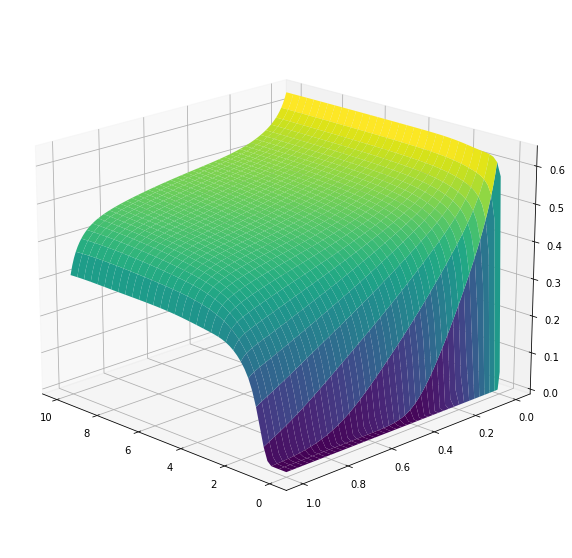

In [29]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_ResNet.graphPINN.NNs[Eidx](TX) #-  solver.graphPINN.NNs[1](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

# CNN

In [30]:
gPINN_CNN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, 'CNN')
N_0 = 1000
N_b = 1000
N_r = 4000
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
solver_CNN = graphPINNSolver(gPINN_CNN, X_r, X_0, X_l, X_u)
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)

Initialized 1 neural nets.


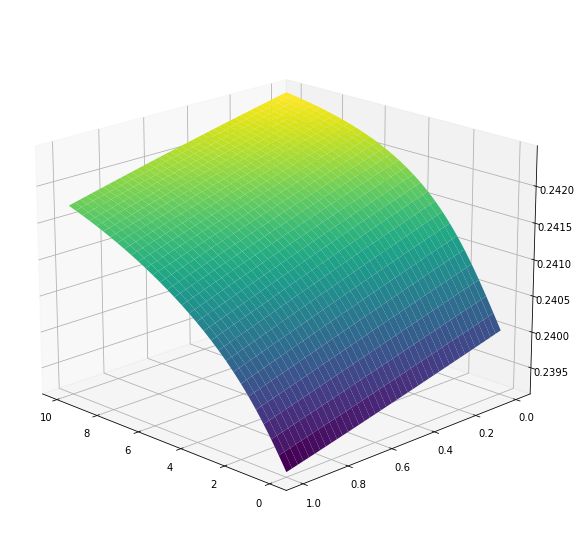

In [31]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_CNN.graphPINN.NNs[Eidx](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

In [32]:
lr = 0.05
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver_CNN.solve_with_TFoptimizer(optim, N=2001)

Start with TF optimizer

 Iter            Loss    Time
-----------------------------

in node  0 alpha  0.7 beta  0.0
inflow:  0

in node  1 alpha  0.0 beta  0.8
outflow:  0
Tensor("add_1:0", shape=(), dtype=float64)
Tensor("add_2:0", shape=(), dtype=float64)
0
0
Tensor("add_9:0", shape=(), dtype=float64)
00000  1.78187421e-01   1.54
00020  6.53391615e-02   1.87
00040  3.27845200e-02   2.26
00060  1.21505855e-02   2.66
00080  1.01261851e-02   3.09
00100  9.49817878e-03   3.56
00120  9.14398441e-03   4.02
00140  8.86842085e-03   4.44
00160  8.62211128e-03   4.89
00180  8.38523395e-03   5.29
00200  8.14977425e-03   5.68
00220  7.91201352e-03   6.09
00240  7.67127919e-03   6.49
00260  8.36649570e-03   6.89
00280  7.38951374e-03   7.33
00300  7.04076461e-03   7.72
00320  6.82457792e-03   8.11
00340  6.62289085e-03   8.49
00360  6.44348131e-03   8.84
00380  6.28474201e-03   9.22
00400  6.14370831e-03   9.61
00420  6.01580436e-03   10.01
00440  5.92219704e-03   10.39
00460  5.80478260e-03   

In [33]:
# print('End with L-BFGS-B algorithm')
# coarse = False

# #X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r*10)
# #solver._updateData(X_r, X_0, X_l, X_u)
# if coarse:
#     ret = solver_CNN.solve_with_ScipyOptimizer(options={'maxiter': 10000,
#                                      'maxfun': 50000,
#                                      'maxcor': 50,
#                                      'maxls': 50,
#                                      'ftol': 1e-12})
# else:
#     ret = solver_CNN.solve_with_ScipyOptimizer(options={'maxiter': 10000,
#                                      'maxfun': 50000,
#                                      'maxcor': 50,
#                                      'maxls': 50,
#                                      'ftol': 1.0*np.finfo(float).eps})
# print(ret.message)

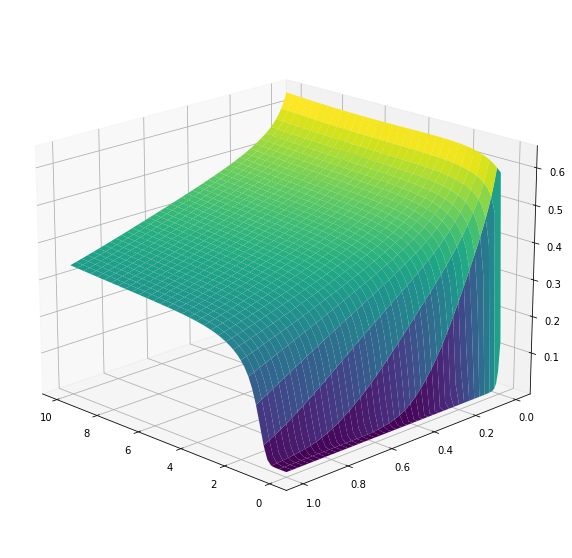

In [34]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_CNN.graphPINN.NNs[Eidx](TX) #-  solver.graphPINN.NNs[1](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

# ResNet CNN

In [35]:
# gPINN_ResNet_CNN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, 'ResNetCNN')
# N_0 = 1000
# N_b = 1000
# N_r = 4000
# X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
# solver_ResNet_CNN = graphPINNSolver(gPINN_ResNet_CNN, X_r, X_0, X_l, X_u)
# X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)

# Recurrent Neural Network

In [36]:
gPINN_RNN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, 'RNN')
N_0 = 1000
N_b = 1000
N_r = 4000
solver_RNN = graphPINNSolver(gPINN_RNN, X_r, X_0, X_l, X_u)
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
#lr = 0.01
#optim = tf.keras.optimizers.Adam(learning_rate=lr)
#print('Start with TF optimizer\n')
#solver.solve_with_TFoptimizer(optim, N=1)

Initialized 1 neural nets.


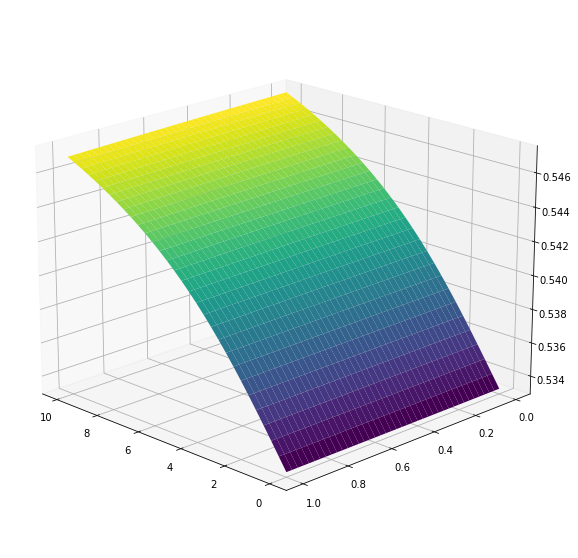

In [37]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_RNN.graphPINN.NNs[Eidx](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

In [38]:
lr = 0.05
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver_RNN.solve_with_TFoptimizer(optim, N=2001)

Start with TF optimizer

 Iter            Loss    Time
-----------------------------

in node  0 alpha  0.7 beta  0.0
inflow:  0

in node  1 alpha  0.0 beta  0.8
outflow:  0
Tensor("add_1:0", shape=(), dtype=float64)
Tensor("add_2:0", shape=(), dtype=float64)
0
0
Tensor("add_9:0", shape=(), dtype=float64)
00000  3.23825395e-01   13.65
00020  1.17621659e-01   15.73
00040  4.06235028e-02   18.06
00060  2.14058929e-02   20.33
00080  9.48131297e-03   22.46
00100  7.99806181e-03   24.77
00120  7.07452486e-03   26.98
00140  6.31560924e-03   29.07
00160  5.90496502e-03   31.14
00180  5.22266134e-03   33.26
00200  4.77734193e-03   35.31
00220  4.37600793e-03   37.43
00240  4.17000253e-03   39.55
00260  3.87892782e-03   41.75
00280  3.41660211e-03   43.87
00300  3.32669992e-03   45.92
00320  2.93456528e-03   47.96
00340  2.94841779e-03   49.96
00360  2.66753099e-03   52.02
00380  2.63987236e-03   54.06
00400  2.55235426e-03   56.13
00420  2.50026886e-03   58.28
00440  2.56745004e-03   60.35
004

In [39]:
print('End with L-BFGS-B algorithm')
coarse = False

#X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r*10)
#solver._updateData(X_r, X_0, X_l, X_u)
if coarse:
    ret = solver_RNN.solve_with_ScipyOptimizer(options={'maxiter': 10000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1e-12})
else:
    ret = solver_RNN.solve_with_ScipyOptimizer(options={'maxiter': 10000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})
print(ret.message)

End with L-BFGS-B algorithm
 Iter            Loss    Time
-----------------------------
02020  1.95233301e-03   2.09
02040  1.94257690e-03   4.14
02060  1.93180723e-03   6.45
02080  1.92652570e-03   8.55
02100  1.92247441e-03   10.45
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


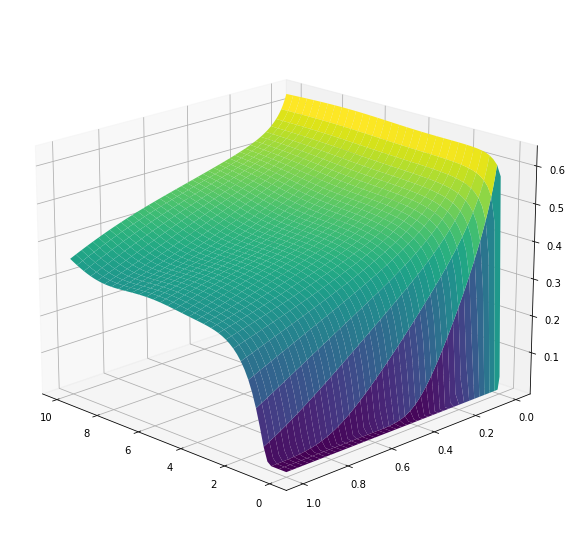

In [40]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_RNN.graphPINN.NNs[Eidx](TX) #-  solver.graphPINN.NNs[1](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

# LSTM

In [41]:
gPINN_LSTM = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, 'LSTM')
N_0 = 1000
N_b = 1000
N_r = 4000
solver_LSTM = graphPINNSolver(gPINN_LSTM, X_r, X_0, X_l, X_u)
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
#lr = 0.01
#optim = tf.keras.optimizers.Adam(learning_rate=lr)
#print('Start with TF optimizer\n')b
#solver.solve_with_TFoptimizer(optim, N=1)

Initialized 1 neural nets.


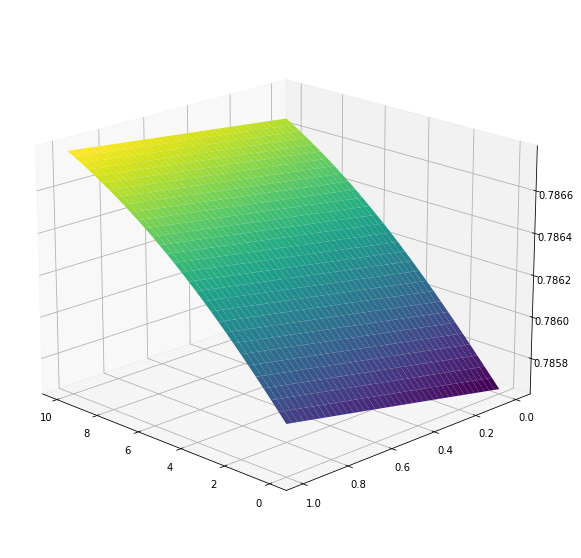

In [42]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_LSTM.graphPINN.NNs[Eidx](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

In [43]:
lr = 0.05
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver_LSTM.solve_with_TFoptimizer(optim, N=2001)

Start with TF optimizer

 Iter            Loss    Time
-----------------------------

in node  0 alpha  0.7 beta  0.0
inflow:  0

in node  1 alpha  0.0 beta  0.8
outflow:  0
Tensor("add_1:0", shape=(), dtype=float64)
Tensor("add_2:0", shape=(), dtype=float64)
0
0
Tensor("add_9:0", shape=(), dtype=float64)
00000  8.30418971e-01   29.82
00020  1.72382393e-01   37.48
00040  7.27232937e-02   46.64
00060  3.68876299e-02   55.29
00080  2.93599909e-02   63.76
00100  9.85633468e-03   72.35
00120  8.18888647e-03   80.90
00140  7.10767499e-03   89.41
00160  6.26929086e-03   97.70
00180  5.48372494e-03   105.95
00200  4.71913595e-03   114.00
00220  4.35908906e-03   121.97
00240  3.85163101e-03   129.98
00260  3.42834374e-03   137.98
00280  3.12389058e-03   145.91
00300  2.93803475e-03   153.84
00320  2.79640714e-03   161.56
00340  2.68717581e-03   170.08
00360  2.60005377e-03   177.77
00380  2.52928222e-03   185.39
00400  2.47055621e-03   192.98
00420  2.42067116e-03   200.49
00440  2.37749244e-0

KeyboardInterrupt: 

In [ ]:
print('End with L-BFGS-B algorithm')
coarse = False

#X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r*10)
#solver._updateData(X_r, X_0, X_l, X_u)
if coarse:
    ret = solver_LSTM.solve_with_ScipyOptimizer(options={'maxiter': 10000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1e-12})
else:
    ret = solver_LSTM.solve_with_ScipyOptimizer(options={'maxiter': 10000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})
print(ret.message)

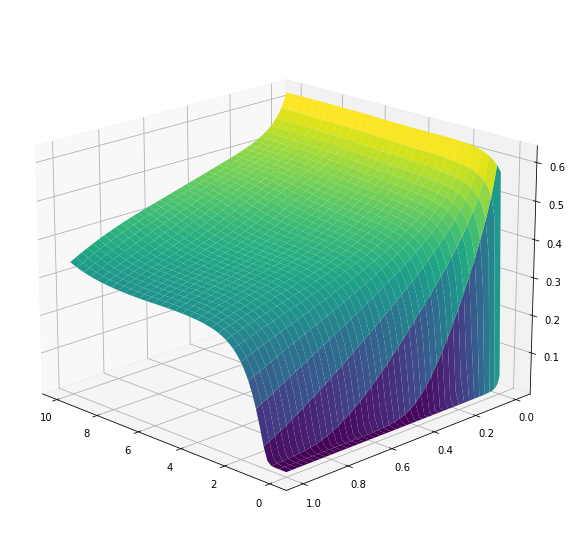

In [44]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_LSTM.graphPINN.NNs[Eidx](TX) #-  solver.graphPINN.NNs[1](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

# FVM

In [45]:
xth_frame = 5
# Time discretization of FVM
nt = N_b * xth_frame
# Spatial discretization of FVM
nx = N_0 + 1

graph_FVM = graph.Example0()
graph_FVM.buildGraph()

fvm_solver = QuantumGraphSolverFVM(graph_FVM)
u_fvm = fvm_solver.solve(nx=nx, nt=nt)

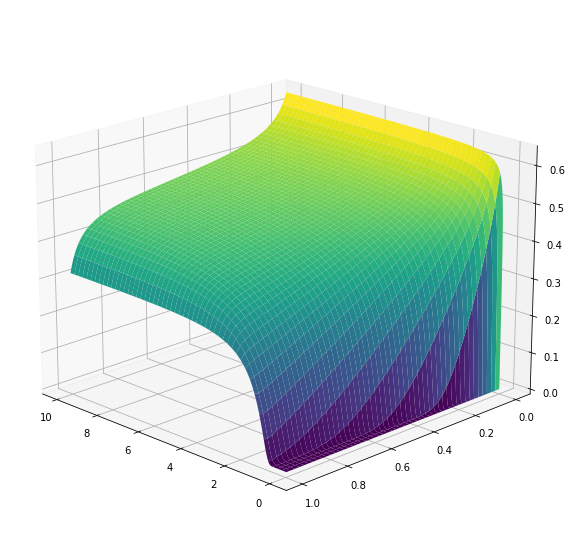

In [46]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

t_fvm = [i * 1./500. for i in range(np.shape(u_fvm)[1])]
x_fvm = [i / nx for i in range(np.shape(u_fvm)[0])]

T, X = tf.meshgrid(t_fvm, x_fvm[:999])
ax.plot_surface(T, X, u_fvm[:999, :], cmap='viridis')
ax.view_init(19, 135)

# Comparsion

In [47]:
Eidx = 0
T, X = tf.meshgrid(t_fvm, x_fvm[:999])
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U_FNN = solver.graphPINN.NNs[Eidx](TX) 
U_FNN = tf.reshape(U_FNN, T.shape)
U_ResNet = solver_ResNet.graphPINN.NNs[Eidx](TX) 
U_ResNet = tf.reshape(U_ResNet, T.shape)
U_CNN = solver_CNN.graphPINN.NNs[Eidx](TX) 
U_CNN = tf.reshape(U_CNN, T.shape)
U_RNN = solver_RNN.graphPINN.NNs[Eidx](TX) 
U_RNN = tf.reshape(U_RNN, T.shape)

In [48]:
print(u_fvm.shape)
print(U_ResNet.shape)
print(U_FNN.shape)
print(U_CNN.shape)
print(U_RNN.shape)

(1001, 5000)
(999, 5000)
(999, 5000)
(999, 5000)
(999, 5000)


In [49]:
print(tf.linalg.norm(U_FNN - u_fvm[:999, :]))
print(tf.linalg.norm(U_ResNet - u_fvm[:999, :]))
print(tf.linalg.norm(U_CNN - u_fvm[:999, :]))
print(tf.linalg.norm(U_RNN - u_fvm[:999, :]))

tf.Tensor(5.91513142408256, shape=(), dtype=float64)
tf.Tensor(8.053447005280013, shape=(), dtype=float64)
tf.Tensor(102.71403129536804, shape=(), dtype=float64)
tf.Tensor(103.22477874605994, shape=(), dtype=float64)


In [50]:
print(np.max(tf.abs(U_FNN - u_fvm[:999, :])))
print(np.max(tf.abs(U_ResNet - u_fvm[:999, :])))
print(np.max(tf.abs(U_CNN - u_fvm[:999, :])))
print(np.max(tf.abs(U_RNN - u_fvm[:999, :])))

0.2684886048506244
0.1469210458800389
0.13135781162785637
0.15340351676464925


In [ ]:
input_shape = (100, 1, 2)
x = tf.random.normal(input_shape)
y = tf.keras.layers.Conv1D(23, 1, activation='sigmoid')(x)
print(y.shape)

# Stuff

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

x_train = tf.random.normal((100,2))

model = Sequential()


model.add(LSTM(128, activation='sigmoid', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, activation='sigmoid'))
model.add(Dropout(0.1))

model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
x_train = tf.random.normal((100, 1, 2))
model(x_train)

In [ ]:
# inputs = tf.random.normal([32, 10, 8])
inputs = tf.random.normal((100,2))
inputs = tf.reshape(inputs, (100, 1, 2))


lstm = tf.keras.layers.LSTM(128)
output = lstm(inputs)
print(output.shape)

lstm = tf.keras.layers.LSTM(4, return_sequences=True, return_state=True)
whole_seq_output, final_memory_state, final_carry_state = lstm(inputs)
print(whole_seq_output.shape)

print(final_memory_state.shape)

print(final_carry_state.shape)
